# User Latent Dirichlet Allocation

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('.'))
torch.autograd.set_detect_anomaly(True)

In [2]:
%load_ext autoreload
%autoreload 2

from lib.lda_models import InductiveLDA, NeuralLDA, NeuralLLNA
from lib import utils as utils

Import Data

In [3]:
class Corpus:
    def __init__(self, datadir):
        filenames = ['train.txt.npy', 'test.txt.npy']
        self.datapaths = [os.path.join(datadir, x) for x in filenames]
        with open(os.path.join(datadir, 'vocab.pkl'), 'rb') as f:
            self.vocab = pickle.load(f)
        self.train, self.test = [
            Data(dp, len(self.vocab)) for dp in self.datapaths]


class Data:
    def __init__(self, datapath, vocab_size):
        data = np.load(datapath, allow_pickle=True, encoding='bytes')
        self.data = np.array([np.bincount(x.astype('int'), minlength=vocab_size) for x in data if np.sum(x)>0])
        self.documents = data
        
    @property
    def size(self):
        return len(self.data)
    
    def get_batch(self, batch_size, start_id=None):
        if start_id is None:
            batch_idx = np.random.choice(np.arange(self.size), batch_size)
        else:
            batch_idx = np.arange(start_id, start_id + batch_size)
        batch_data = self.data[batch_idx]
        data_tensor = torch.from_numpy(batch_data).float()
        return data_tensor

In [4]:
corpus = Corpus("../data/20news")

In [5]:
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [6]:
X_document = corpus.train.data

In [7]:
num_docs, vocab_size = X_document.shape
print(f"Number of documents: {num_docs}, vocab size: {vocab_size}")

Number of documents: 11258, vocab size: 1995


In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X): self.X = X
    def __len__(self): return len(self.X)
    def __getitem__(self, index): return self.X[index]

In [9]:
dataset = Dataset(torch.tensor(X_document).to(torch.float32))

In [10]:
num_topics = 50
prodlda = False
conv = False
num_layers = 1 # num hidden layers in the NN block. There are at least (1+num_heads) hidden layers in the encoder and decoder. num_layers comes on top of those. Total number of hidden layers is (1+num_layers+num_heads).
num_neurons = 100
dropout = True
dropout_rate = 0.25
batch_normalization = True
prior_param = {'alpha': 1.0}
decoder_temperature = 0.5
encoder_temperature = 0.5

In [11]:
# NeuralModel, prior_param = NeuralLLNA, {"mu": 0.0, "sigma": 1.0}
# NeuralModel = NeuralLDA
NeuralModel = InductiveLDA

In [12]:
model = NeuralModel(input_dim=vocab_size,
                    num_topics=num_topics,
                    prior_param=prior_param.copy(),
                    conv=conv,
                    prodlda=prodlda,
                    decoder_temperature=decoder_temperature,
                    num_hidden_layers=num_layers,
                    num_neurons=num_neurons,
                    dropout=dropout,
                    dropout_rate=dropout_rate,
                    batch_normalization=batch_normalization,
                    )

In [13]:
lr = 5e-3
batch_size = 200
num_epochs = 100
beta = 1.0
learn_prior = True

In [14]:
# Train the model using default partitioning choice 
model.fit(lr=lr,
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True),
            epochs = num_epochs,
            beta = beta,
            mc_samples = 2,
            learn_prior = learn_prior,
            tensorboard = False,
            )

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1%|          | 1/100 [00:01<01:45,  1.07s/it]/home/kbolat/miniconda3/envs/torchenv/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
                                                      
Epoch:   2%|▏         | 2/100 [00:04<02:52,  1.76s/it]             

Iteration: 100 -- ELBO=-6.65e+02 / RLL=-6.57e+02 / KL=8.25e+00


                                                      
Epoch:   4%|▍         | 4/100 [00:06<02:28,  1.55s/it]             

Iteration: 200 -- ELBO=-4.96e+02 / RLL=-4.90e+02 / KL=6.31e+00


                                                      
Epoch:   6%|▌         | 6/100 [00:09<02:20,  1.49s/it]             

Iteration: 300 -- ELBO=-6.39e+02 / RLL=-6.32e+02 / KL=6.36e+00


                                                      
Epoch:   8%|▊         | 8/100 [00:12<02:14,  1.47s/it]    

Iteration: 400 -- ELBO=-4.79e+02 / RLL=-4.74e+02 / KL=4.75e+00


                                                      
Epoch:   9%|▉         | 9/100 [00:14<02:13,  1.46s/it]             

Iteration: 500 -- ELBO=-6.92e+02 / RLL=-6.87e+02 / KL=5.49e+00


                                                       
Epoch:  11%|█         | 11/100 [00:17<02:09,  1.46s/it]            

Iteration: 600 -- ELBO=-7.33e+02 / RLL=-7.27e+02 / KL=6.08e+00


                                                       
Epoch:  13%|█▎        | 13/100 [00:19<02:06,  1.45s/it]            

Iteration: 700 -- ELBO=-4.98e+02 / RLL=-4.94e+02 / KL=4.44e+00


                                                       
Epoch:  15%|█▌        | 15/100 [00:22<02:03,  1.46s/it]   

Iteration: 800 -- ELBO=-5.81e+02 / RLL=-5.75e+02 / KL=6.05e+00


                                                       
Epoch:  16%|█▌        | 16/100 [00:24<02:02,  1.46s/it]            

Iteration: 900 -- ELBO=-7.83e+02 / RLL=-7.75e+02 / KL=7.62e+00


                                                       
Epoch:  18%|█▊        | 18/100 [00:27<01:58,  1.45s/it]            

Iteration: 1000 -- ELBO=-5.08e+02 / RLL=-5.02e+02 / KL=5.65e+00


                                                       
Epoch:  20%|██        | 20/100 [00:30<01:59,  1.49s/it]            

Iteration: 1100 -- ELBO=-6.13e+02 / RLL=-6.06e+02 / KL=7.31e+00


                                                       
Epoch:  22%|██▏       | 22/100 [00:32<01:54,  1.47s/it]   

Iteration: 1200 -- ELBO=-5.93e+02 / RLL=-5.85e+02 / KL=7.78e+00


                                                       
Epoch:  23%|██▎       | 23/100 [00:35<01:53,  1.47s/it]            

Iteration: 1300 -- ELBO=-6.11e+02 / RLL=-6.03e+02 / KL=7.10e+00


                                                       
Epoch:  25%|██▌       | 25/100 [00:38<01:56,  1.56s/it]            

Iteration: 1400 -- ELBO=-6.21e+02 / RLL=-6.12e+02 / KL=9.27e+00


                                                       
Epoch:  27%|██▋       | 27/100 [00:40<01:50,  1.51s/it]            

Iteration: 1500 -- ELBO=-6.06e+02 / RLL=-5.97e+02 / KL=9.18e+00


                                                       
Epoch:  29%|██▉       | 29/100 [00:43<01:45,  1.49s/it]   

Iteration: 1600 -- ELBO=-5.72e+02 / RLL=-5.63e+02 / KL=8.69e+00


                                                       
Epoch:  30%|███       | 30/100 [00:45<01:43,  1.48s/it]            

Iteration: 1700 -- ELBO=-7.84e+02 / RLL=-7.73e+02 / KL=1.15e+01


                                                       
Epoch:  32%|███▏      | 32/100 [00:48<01:40,  1.47s/it]            

Iteration: 1800 -- ELBO=-6.41e+02 / RLL=-6.32e+02 / KL=9.34e+00


                                                       
Epoch:  34%|███▍      | 34/100 [00:50<01:36,  1.46s/it]            

Iteration: 1900 -- ELBO=-5.74e+02 / RLL=-5.63e+02 / KL=1.04e+01


                                                       
Epoch:  36%|███▌      | 36/100 [00:53<01:33,  1.46s/it]           

Iteration: 2000 -- ELBO=-6.23e+02 / RLL=-6.12e+02 / KL=1.11e+01


                                                       
Epoch:  37%|███▋      | 37/100 [00:56<01:32,  1.46s/it]            

Iteration: 2100 -- ELBO=-6.66e+02 / RLL=-6.53e+02 / KL=1.37e+01


                                                       
Epoch:  39%|███▉      | 39/100 [00:58<01:29,  1.47s/it]            

Iteration: 2200 -- ELBO=-4.83e+02 / RLL=-4.71e+02 / KL=1.21e+01


                                                       
Epoch:  41%|████      | 41/100 [01:01<01:26,  1.46s/it]            

Iteration: 2300 -- ELBO=-4.93e+02 / RLL=-4.81e+02 / KL=1.27e+01


                                                       
Epoch:  43%|████▎     | 43/100 [01:03<01:23,  1.46s/it]           

Iteration: 2400 -- ELBO=-6.64e+02 / RLL=-6.49e+02 / KL=1.48e+01


                                                       
Epoch:  44%|████▍     | 44/100 [01:06<01:21,  1.46s/it]            

Iteration: 2500 -- ELBO=-5.18e+02 / RLL=-5.05e+02 / KL=1.31e+01


                                                       
Epoch:  46%|████▌     | 46/100 [01:08<01:18,  1.46s/it]            

Iteration: 2600 -- ELBO=-5.58e+02 / RLL=-5.42e+02 / KL=1.56e+01


                                                       
Epoch:  48%|████▊     | 48/100 [01:11<01:16,  1.48s/it]            

Iteration: 2700 -- ELBO=-5.81e+02 / RLL=-5.65e+02 / KL=1.53e+01


                                                       
Epoch:  50%|█████     | 50/100 [01:14<01:13,  1.47s/it]           

Iteration: 2800 -- ELBO=-7.89e+02 / RLL=-7.72e+02 / KL=1.71e+01


                                                       
Epoch:  52%|█████▏    | 52/100 [01:16<01:10,  1.48s/it]            

Iteration: 2900 -- ELBO=-5.95e+02 / RLL=-5.79e+02 / KL=1.59e+01


                                                       
Epoch:  53%|█████▎    | 53/100 [01:19<01:09,  1.48s/it]            

Iteration: 3000 -- ELBO=-4.64e+02 / RLL=-4.49e+02 / KL=1.44e+01


                                                       
Epoch:  55%|█████▌    | 55/100 [01:22<01:07,  1.50s/it]            

Iteration: 3100 -- ELBO=-5.74e+02 / RLL=-5.57e+02 / KL=1.65e+01


                                                       
Epoch:  57%|█████▋    | 57/100 [01:24<01:03,  1.48s/it]           

Iteration: 3200 -- ELBO=-7.77e+02 / RLL=-7.58e+02 / KL=1.89e+01


                                                       
Epoch:  59%|█████▉    | 59/100 [01:27<01:00,  1.48s/it]            

Iteration: 3300 -- ELBO=-5.99e+02 / RLL=-5.82e+02 / KL=1.70e+01


                                                       
Epoch:  60%|██████    | 60/100 [01:29<00:58,  1.47s/it]            

Iteration: 3400 -- ELBO=-6.26e+02 / RLL=-6.09e+02 / KL=1.68e+01


                                                       
Epoch:  62%|██████▏   | 62/100 [01:32<00:55,  1.47s/it]            

Iteration: 3500 -- ELBO=-5.51e+02 / RLL=-5.33e+02 / KL=1.76e+01


                                                       
Epoch:  64%|██████▍   | 64/100 [01:34<00:52,  1.47s/it]           

Iteration: 3600 -- ELBO=-6.03e+02 / RLL=-5.86e+02 / KL=1.68e+01


                                                       
Epoch:  66%|██████▌   | 66/100 [01:37<00:50,  1.47s/it]            

Iteration: 3700 -- ELBO=-5.80e+02 / RLL=-5.62e+02 / KL=1.86e+01


                                                       
Epoch:  67%|██████▋   | 67/100 [01:40<00:48,  1.47s/it]            

Iteration: 3800 -- ELBO=-6.07e+02 / RLL=-5.88e+02 / KL=1.87e+01


                                                       
Epoch:  69%|██████▉   | 69/100 [01:42<00:45,  1.47s/it]            

Iteration: 3900 -- ELBO=-5.57e+02 / RLL=-5.38e+02 / KL=1.86e+01


                                                       
Epoch:  71%|███████   | 71/100 [01:45<00:42,  1.47s/it]            

Iteration: 4000 -- ELBO=-6.35e+02 / RLL=-6.18e+02 / KL=1.72e+01


                                                       
Epoch:  73%|███████▎  | 73/100 [01:47<00:39,  1.47s/it]            

Iteration: 4100 -- ELBO=-5.78e+02 / RLL=-5.60e+02 / KL=1.82e+01


                                                       
Epoch:  74%|███████▍  | 74/100 [01:50<00:38,  1.47s/it]            

Iteration: 4200 -- ELBO=-6.46e+02 / RLL=-6.28e+02 / KL=1.87e+01


                                                       
Epoch:  76%|███████▌  | 76/100 [01:53<00:35,  1.47s/it]            

Iteration: 4300 -- ELBO=-6.41e+02 / RLL=-6.22e+02 / KL=1.90e+01


                                                       
Epoch:  78%|███████▊  | 78/100 [01:55<00:32,  1.49s/it]            

Iteration: 4400 -- ELBO=-7.45e+02 / RLL=-7.25e+02 / KL=1.99e+01


                                                       
Epoch:  80%|████████  | 80/100 [01:58<00:29,  1.50s/it]            

Iteration: 4500 -- ELBO=-5.50e+02 / RLL=-5.31e+02 / KL=1.93e+01


                                                       
Epoch:  81%|████████  | 81/100 [02:00<00:28,  1.50s/it]            

Iteration: 4600 -- ELBO=-6.73e+02 / RLL=-6.53e+02 / KL=2.00e+01


                                                       
Epoch:  83%|████████▎ | 83/100 [02:03<00:25,  1.48s/it]            

Iteration: 4700 -- ELBO=-5.81e+02 / RLL=-5.61e+02 / KL=1.97e+01


                                                       
Epoch:  85%|████████▌ | 85/100 [02:06<00:22,  1.48s/it]            

Iteration: 4800 -- ELBO=-6.70e+02 / RLL=-6.48e+02 / KL=2.13e+01


                                                       
Epoch:  87%|████████▋ | 87/100 [02:08<00:19,  1.47s/it]            

Iteration: 4900 -- ELBO=-6.82e+02 / RLL=-6.62e+02 / KL=2.09e+01


                                                       
Epoch:  88%|████████▊ | 88/100 [02:11<00:17,  1.47s/it]            

Iteration: 5000 -- ELBO=-5.61e+02 / RLL=-5.41e+02 / KL=1.98e+01


                                                       
Epoch:  90%|█████████ | 90/100 [02:13<00:14,  1.47s/it]            

Iteration: 5100 -- ELBO=-6.31e+02 / RLL=-6.10e+02 / KL=2.16e+01


                                                       
Epoch:  92%|█████████▏| 92/100 [02:16<00:11,  1.47s/it]            

Iteration: 5200 -- ELBO=-5.70e+02 / RLL=-5.51e+02 / KL=1.86e+01


                                                       
Epoch:  94%|█████████▍| 94/100 [02:18<00:08,  1.47s/it]            

Iteration: 5300 -- ELBO=-6.27e+02 / RLL=-6.08e+02 / KL=1.97e+01


                                                       
Epoch:  95%|█████████▌| 95/100 [02:21<00:07,  1.46s/it]            

Iteration: 5400 -- ELBO=-5.60e+02 / RLL=-5.40e+02 / KL=2.05e+01


                                                       
Epoch:  97%|█████████▋| 97/100 [02:24<00:04,  1.50s/it]            

Iteration: 5500 -- ELBO=-7.60e+02 / RLL=-7.37e+02 / KL=2.30e+01


                                                       
Epoch:  99%|█████████▉| 99/100 [02:26<00:01,  1.48s/it]            

Iteration: 5600 -- ELBO=-4.84e+02 / RLL=-4.65e+02 / KL=1.97e+01


                                                        
Iteration in Epoch: 100%|██████████| 57/57 [00:01<00:00, 39.20it/s]

Iteration: 5700 -- ELBO=-8.19e+02 / RLL=-7.96e+02 / KL=2.26e+01


In [26]:
model.get_prior_params()

tensor([0.3099, 0.4807, 0.2176, 1.1569, 0.4210, 0.1922, 0.3271, 0.9628, 0.4790,
        0.5742, 0.3566, 1.4646, 0.3131, 0.4169, 0.4414, 0.5714, 0.6545, 0.2554,
        0.3189, 0.4832, 0.3679, 0.3134, 0.3316, 0.3011, 0.3390, 0.2091, 0.4431,
        0.3335, 0.2844, 0.3327, 0.8802, 0.2575, 0.4042, 0.2156, 0.3167, 0.3311,
        0.8556, 0.3276, 0.8866, 0.2643, 0.3845, 0.5225, 1.1200, 0.6307, 0.3171,
        0.3397, 0.3033, 0.3549, 0.5953, 0.3397], grad_fn=<SoftplusBackward0>)

In [27]:
model.decoder.get_beta().detach()

tensor([[2.1995e-07, 6.8660e-06, 2.7452e-03,  ..., 7.9394e-07, 3.8417e-07,
         3.8532e-07],
        [1.2983e-07, 1.8918e-04, 1.3536e-02,  ..., 1.9852e-04, 7.4385e-06,
         6.4228e-09],
        [4.2763e-09, 2.9884e-05, 1.8029e-02,  ..., 7.1468e-07, 3.7180e-08,
         2.8222e-05],
        ...,
        [3.6749e-07, 2.1967e-03, 2.3075e-03,  ..., 8.8084e-05, 4.8963e-07,
         3.1720e-09],
        [8.4535e-08, 6.3969e-05, 1.0155e-02,  ..., 4.2998e-09, 1.9751e-08,
         5.4217e-09],
        [9.9691e-08, 3.4520e-03, 5.3143e-03,  ..., 2.5566e-07, 8.6839e-05,
         9.1595e-08]])

In [28]:
model.eval()

InductiveLDA(
  (encoder): DirichletNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=1995, out_features=100, bias=True)
            (1): Softplus(beta=1, threshold=20)
          )
          (middle_layers): ModuleList(
            (0): Sequential(
              (0): Linear(in_features=100, out_features=100, bias=True)
              (1): Softplus(beta=1, threshold=20)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=100, out_features=100, bias=True)
            (1): Softplus(beta=1, threshold=20)
          )
        )
        (alpha): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=100, out_features=100, bias=True)
            (1): Softplus(beta=1, threshold=20)
          )
          (middle_layers): ModuleList()
          (output_layer): Sequential(
            (0): Linear(in_feat

In [29]:
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora

In [30]:
## turn the encoding in corpus.train.documents into a list of list of words using the vocab
id2word = {v: k for k, v in corpus.vocab.items()}
texts = [[id2word[i] for i in doc] for doc in corpus.train.documents]

In [31]:
Beta = model.decoder.get_beta().detach().numpy()
# Beta = model.decoder.beta_unnorm.detach().numpy()

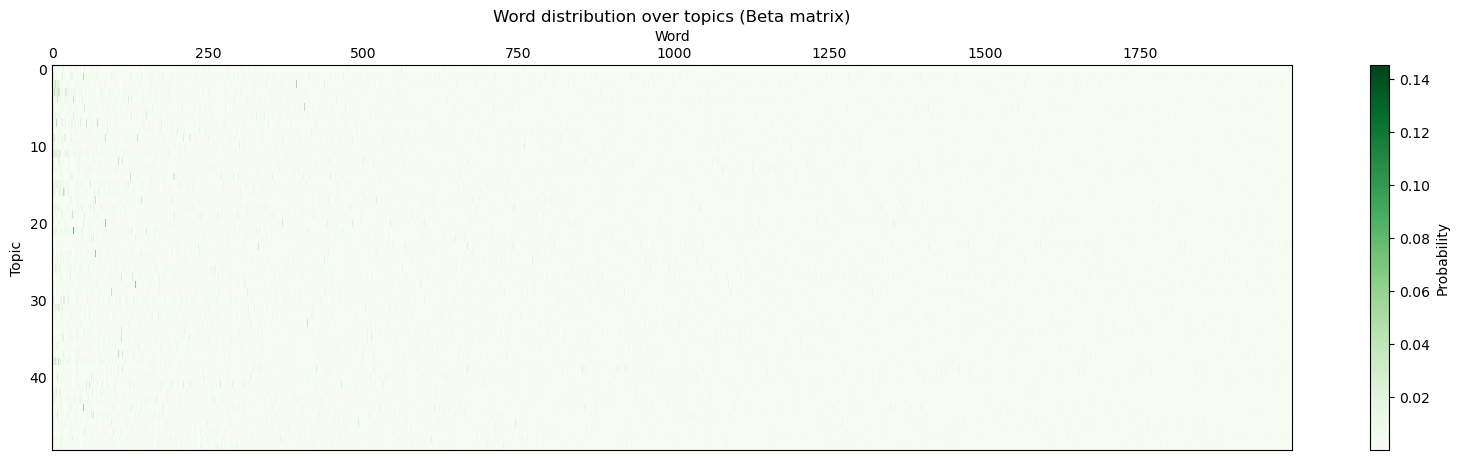

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
im = ax.imshow((Beta), aspect='auto', cmap='Greens', interpolation='none')
ax.set_title('Word distribution over topics (Beta matrix)')
ax.set_ylabel('Topic')
ax.set_xlabel('Word')
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax, label='Probability')
plt.show()

In [33]:
result = {}
result["topic-word-matrix"] = Beta

top_k = 10

if top_k > 0:
    topics_output = []
    for topic in result["topic-word-matrix"]:
        top_k_words = list(reversed([id2word[i] for i in np.argsort(topic)[-top_k:]]))
        topics_output.append(top_k_words)
    result["topics"] = topics_output

In [34]:
result["topics"]

[['health',
  'program',
  'president',
  'year',
  'care',
  'child',
  'government',
  'medical',
  'national',
  'american'],
 ['drive',
  'use',
  'work',
  'system',
  'get',
  'problem',
  'chip',
  'one',
  'computer',
  'disk'],
 ['db',
  'say',
  'go',
  'people',
  'one',
  'armenians',
  'armenian',
  'come',
  'kill',
  'apartment'],
 ['get',
  'people',
  'think',
  'go',
  'like',
  'want',
  'know',
  'thing',
  'make',
  'say'],
 ['god',
  'people',
  'life',
  'christian',
  'believe',
  'religion',
  'man',
  'die',
  'say',
  'hell'],
 ['file',
  'entry',
  'output',
  'program',
  'use',
  'section',
  'rule',
  'line',
  'build',
  'info'],
 ['jesus',
  'god',
  'christian',
  'say',
  'law',
  'church',
  'bible',
  'truth',
  'one',
  'word'],
 ['know',
  'anyone',
  'thanks',
  'please',
  'help',
  'look',
  'find',
  'question',
  'like',
  'work'],
 ['post',
  'group',
  'information',
  'list',
  'send',
  'internet',
  'mail',
  'address',
  'email',
  'new

In [35]:
# Initialize metric
npmi = CoherenceModel(
    topics=result["topics"],
    texts=texts,
    corpus=corpus.train.data,
    dictionary=Dictionary(texts),
    coherence="c_npmi",
    topn=top_k)

In [36]:
npmi.get_coherence()

0.09554914127426517